## My approach to Kaggle's LANL Earthquake Prediction
Welcome! In this notebook I will go over my approach to my first [Kaggle competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction).  
I will go over my thought process, my results, and the lessons that I have learned.

In [1]:
import os
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from dtsckit.utils import read_pickle
from lanl.dataset import get_quake_indices, get_sample
from lanl.segmenter import SpikeSegmenter, plot_segments

### EDA:
- Training data is composed of a single laboratory earthquake simulation with 16 continuous earthquakes
- Each point in the series has an acoustic value along with the time remaining until the next earthquake
- Entire experiment spans a few minutes (the resolution is very high, each time step is ~ 1e-9 seconds)
- The acoustic values seem to have a constant, polulation mean with the variation sporadically spiking
- Each testing segment has only 150000 points and are drawn from simulations independent from the training run
- Task seems hard... predict the next earthquake given a small snippet of acoustic values

In [2]:
ROOT_DIR = '/home/mchobanyan/data/kaggle/lanl_earthquake/'
TRAIN_FILE = os.path.join(ROOT_DIR, 'train.pkl')
df = read_pickle(TRAIN_FILE)
data = df.values
n = len(data)
print(f'Data ready: {n} total timesteps')

Data ready: 629145480 total timesteps


In [3]:
quake_indices = get_quake_indices(df.iloc[:, 1])
print(f'Number of training earthquakes = {len(quake_indices)-1}')

Number of training earthquakes = 16


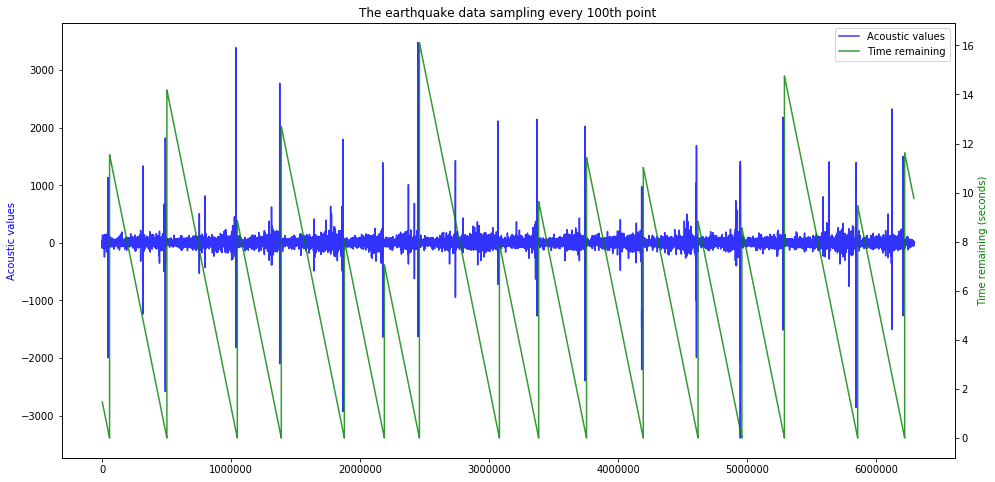

In [4]:
def plot_earthquakes_with_time(acoustic_values, time_remaining, title, figsize=(16, 8)):
    data_idx = np.arange(len(acoustic_values))
    fig, ax1 = plt.subplots(figsize=(16, 8))
    acoustic_plot = ax1.plot(data_idx, acoustic_values, label='Acoustic values', c='blue', alpha=0.8)
    ax1.set_ylabel('Acoustic values', color='blue')

    ax2 = ax1.twinx()
    time_plot = ax2.plot(data_idx, time_remaining, label='Time remaining', c='green', alpha=0.8)
    ax2.set_ylabel('Time remaining (seconds)', color='green')

    plots = acoustic_plot + time_plot
    labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, labels, loc='best')
    plt.title(title)
    plt.show()


plot_earthquakes_with_time(data[::100, 0], data[::100, 1], 'The earthquake data sampling every 100th point')

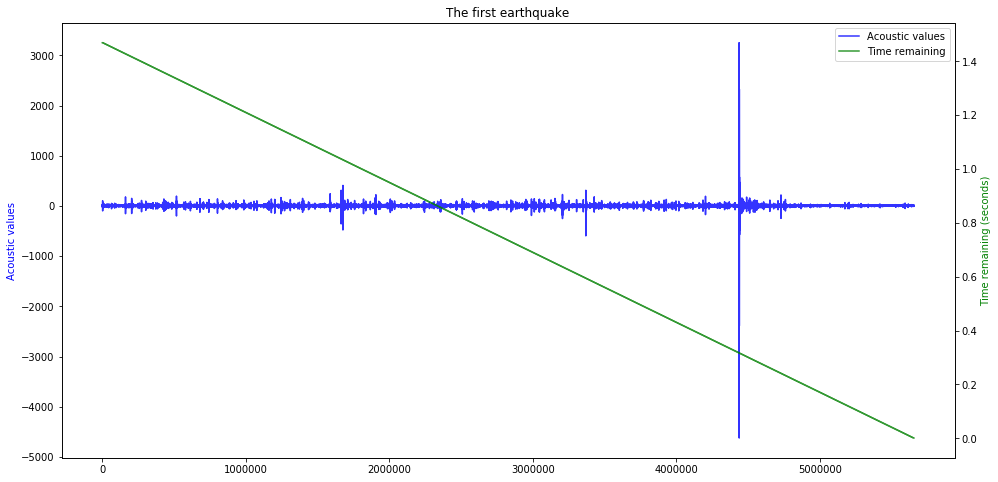

In [5]:
first_earthquake = data[0:quake_indices[1]]
plot_earthquakes_with_time(first_earthquake[:, 0], first_earthquake[:, 1], 'The first earthquake')

Testing segment: 150000 timesteps


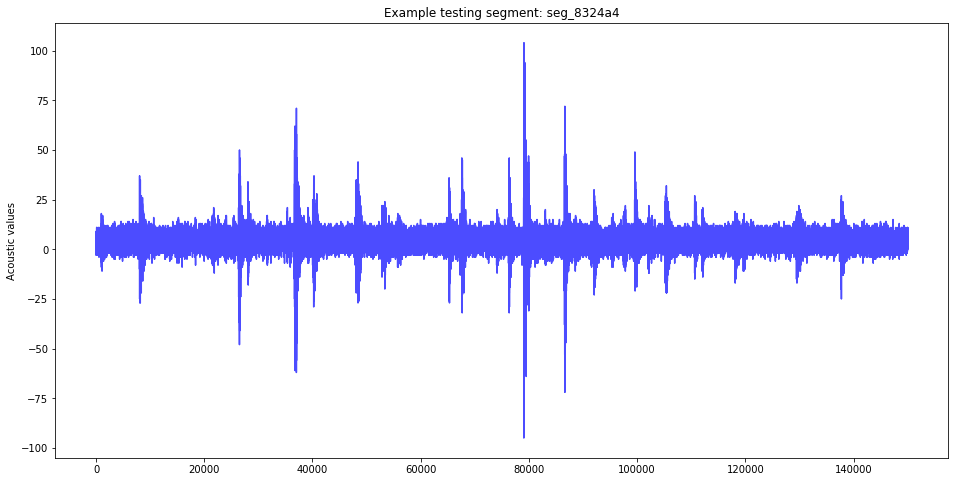

In [6]:
test_segment = read_csv(os.path.join(ROOT_DIR, 'test/seg_8324a4.csv')).values.squeeze()
print(f'Testing segment: {len(test_segment)} timesteps')
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(np.arange(len(test_segment)), test_segment, c='blue', alpha=0.7)
ax.set_ylabel('Acoustic values')
plt.title('Example testing segment: seg_8324a4')
plt.show()

### Approach 1: 
- My first approach was inspired from the following kernel: 
https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series
- The idea is to create a data loader that serves batches of sampled, continuous acoustic samples
- Each sampled acoustic sequence has 150000 points (same as the test set) and the target time remaining at the end of the sequence
- Each acoustic sequence is then binned into regular intervals, hand engineered features are extracted, and a GRU is applied
- The extracted features are statistics measuring the distribution of acoustic values with focus on the variation
- Example features: quantiles on raw data and absolute value data, skew, kurtosis
- Validation score: **1.68**

### Approach 2:
- My second approach replaced the hand-engineered features with a 1D CNN feature extractor
- I had a feeling that convolutions would serve well here to automatically extract the important features from the local acoustic neighborhoods
- However, it did not lower the validation score

### Approach 3:
- Keeping with the same idea, I wondered if the reason the CNN feature extractor failed is because the data is too noisy
- If the model is overly complex, it may be trying to build features based off of the random noise in the acoustic data
- So I trained a separate convolutional autoencoder and used it as a fixed feature extractor for the GRU.
- Again, this did not help...

### Approach 4:
- After taking some time off, I switched my focus to identifying when the acoustic values are "excited" and spike up
- My intuition was that segmenting the acoustic sequence based on changes in variance would be smarter than just binning at regular intervals
- First, the population $\mu$ and $\sigma$ were estimated by filtering out all acoustic values that exceeded an acoustic threshold (~20)
- Then, the sequence was binned into windows of 300 points. Each window was labeled as excited or not based on a $\mu$ + 2*$\sigma$ margin and adjacent bins of the same type were joined together.
- I kept the original GRU approach with hand engineered features, except the results of the SpikeSegmenter were used instead of regular bins.
- This slightly lowered the validation score to **1.66**.	

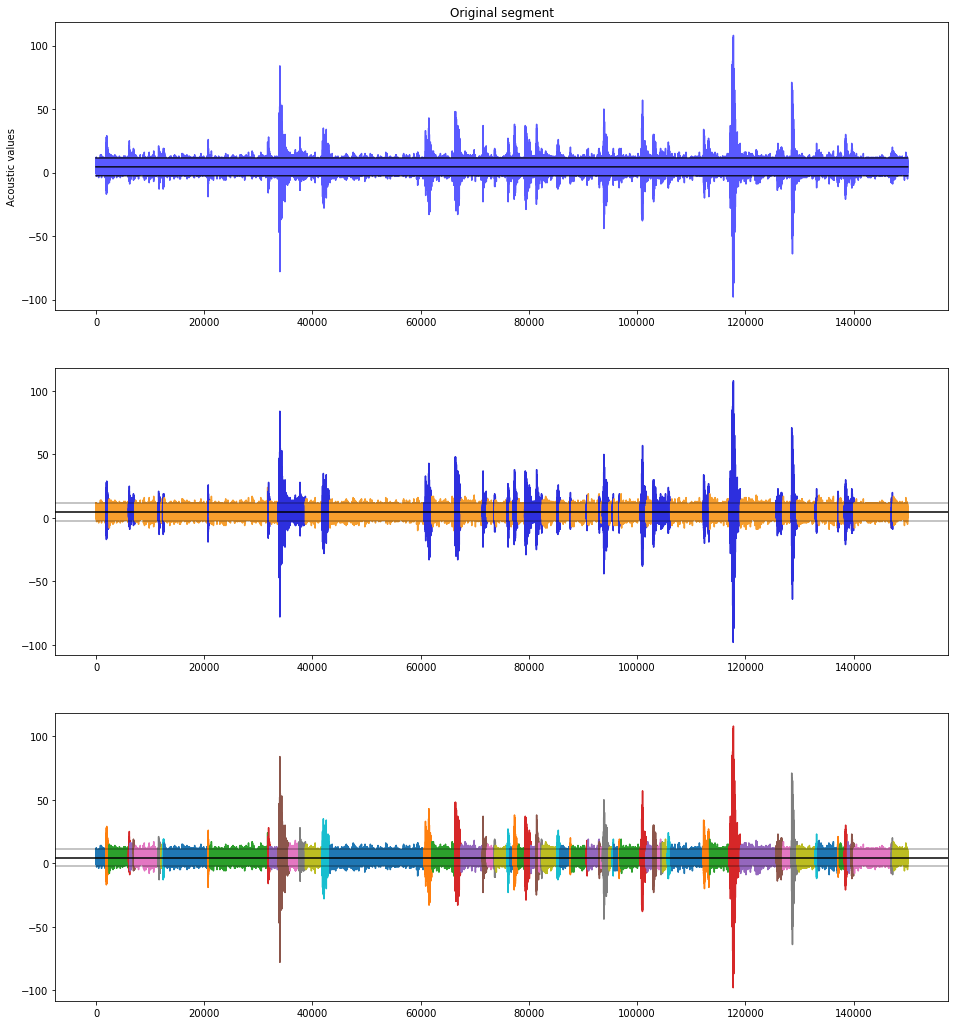

In [24]:
mu = 4.5
sigma = 3.5

# define the segmenter, get an acoustic sample, calculate the cutoffs
segmenter = SpikeSegmenter(mu=3.5, sigma=4.5, window_size=300)
acoustic_sample = get_sample(data, seqlen=150000)[:, 0]
cutoffs = segmenter(acoustic_sample)

# plot the raw signal with a mu +- 2*sigma margin
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 18))
ax1.plot(np.arange(150000), acoustic_sample, c='blue', alpha=0.65)
ax1.plot(np.arange(150000), 150000*[mu], c='black', alpha=0.9)
ax1.plot(np.arange(150000), 150000*[mu+2*sigma], c='black', alpha=0.8)
ax1.plot(np.arange(150000), 150000*[mu-2*sigma], c='black', alpha=0.8)
ax1.set_title('Original segment')
ax1.set_ylabel('Acoustic values')

# plot the results of the segmenter
# blue segments represent "excited" segments, orange represents "normal" behavior
plot_segments(ax2, acoustic_sample, cutoffs, False, mu, sigma, alpha=0.3)

# plot the results of the segmenter again instead this time
# each segment is assigned a random color to get a different visual
plot_segments(ax3, acoustic_sample, cutoffs, True, mu, sigma, alpha=0.3)

plt.show()

### Exploring spectral analysis:
Since the acoustic data comes in the form of a time-dependent signal, I figured this would be a good opportunity to learn about spectral analysis, namely:
- Fourier Transform
- Spectrogram
- Wavelet Transform

### Fourier Transform
- The fourier transform takes a time-dependent signal and maps it into the frequency domain, where the signal is approximated as a sum of sinusoidal waves.
- In general terms, the process involves calculating the dot product between the raw signal with sinusoids of varying frequencies. 
- The waves that best match the signal will result in higher dot products (you can think of this as a measure of correlation). 
- The power spectrum allows us to visualize which frequency had the highest impact on the approximation.
- The problem is that fourier transform loses all notion of time, meaning we cannot infer when a particular frequency occurs in the original signal

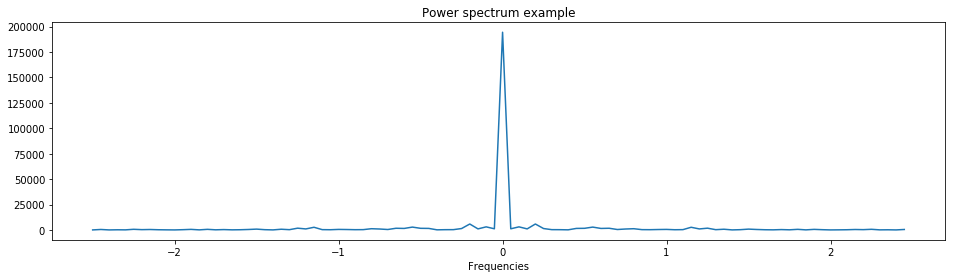

In [47]:
sig = acoustic_sample[:100]
power = np.abs(np.fft.fft(sig)) ** 2

freqs = np.fft.fftfreq(len(sig), 1/5)
idx = np.argsort(freqs)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(freqs[idx], power[idx])
ax.set_title('Power spectrum example')
ax.set_xlabel('Frequencies')
plt.show()

### Spectrogram

### Wavelet Transform

In [10]:
# researched spectral analysis techniques
# discuss FFT/power spectrum, spectrogram, wavelet transform
# discuss how you learned that wavelet transforms are really just specific 1d convolutions

In [11]:
# show a power spectrum (not enough info, when did the sinusoid happen?)

In [12]:
# show a spectrogram (good compromise)

In [13]:
# show a wavelet transform (too time consuming for each segment, too much info on entire segment)

In [14]:
# approach 5: rewrote the segmenter so that it can return only spiked segments along with info on how much time 
# elapsed. Then a model was constructed with two parts: a GRU model that takes the sequence of spiked segments
# and a second model that applies a convolution on the spectrograms. Results were then concatenated and 
# passed through linear layers to output a final prediction

In [15]:
# show the segmenter when it only returns the spikes

In [16]:
# appraoch 6: still had a feeling that the 1d convolutions would be useful. Kept the same approach with a joint
# model. Now, there would be three submodels, with a new one that applies conv 1d on the entire acoustic segment.
# This time I added more convolutional layers (which in turn made me add batch norm layers after the convs),
# and also I replaced pooling with strided convolutions

In [17]:
# my final result on the private test set was ...
# unfortunately, as this was my first kaggle competition, I missed the deadline for the submission
# not realizing that the submission time was UTC not EST...
# would have placed me at 269th out of 4540 (bronze)

# some successful ideas others had:
# making the training set resemble the testing set

In [19]:
# lessons learned:
# - intro to RNNs, sequence modeling
# - intro to spectral analysis techniques (fourier transform, spectrogram, wavelet)
# - take part in the discussions and kaggle kernels. There really is a great community there.
#   can help avoid writing a lot of boiler-plate code and can help you brainstorm new ideas.
# - submit early and often and try to wrap up your work at least a day in advance of the submission deadline :D